# Import Libraries

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Download Data

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Plot Examples

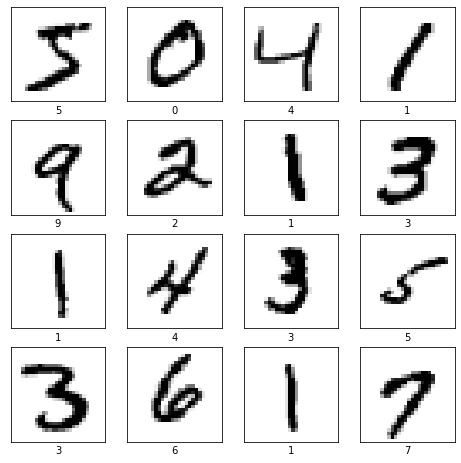

In [5]:
plt.figure(figsize = (8, 8))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[i], cmap = 'binary')
    plt.xlabel(str(y_train[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

# Normalize Data

In [6]:
X_train.shape

(60000, 28, 28)

In [7]:
X_test.shape

(10000, 28, 28)

In [8]:
# reshape the array
X_train = np.reshape(X_train, (60000, 28 * 28))
X_test = np.reshape(X_test, (10000, 28 * 28))

In [9]:
X_train.shape

(60000, 784)

In [10]:
X_train = X_train / 255.0
X_test = X_test / 255.0

# Create a Neural Network Model

In [11]:
model = tf.keras.models.Sequential()
# we are using the sigmoid activation to make the visualization part better.
# if relu is used, you need to normalize the results later.
model.add(tf.keras.layers.Dense(32, activation = 'sigmoid', input_shape = (784, )))
model.add(tf.keras.layers.Dense(32, activation = 'sigmoid'))
model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

In [12]:
# for loss = sparse cross entropy we do not need to worry about one hot encoding
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Train the model

In [16]:
# fitting the model on the training data
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 20, batch_size = 1024, verbose = 2)

Epoch 1/20
59/59 - 1s - loss: 0.3348 - accuracy: 0.9176 - val_loss: 0.3231 - val_accuracy: 0.9182
Epoch 2/20
59/59 - 1s - loss: 0.3111 - accuracy: 0.9223 - val_loss: 0.3031 - val_accuracy: 0.9211
Epoch 3/20
59/59 - 1s - loss: 0.2917 - accuracy: 0.9258 - val_loss: 0.2862 - val_accuracy: 0.9261
Epoch 4/20
59/59 - 1s - loss: 0.2754 - accuracy: 0.9288 - val_loss: 0.2728 - val_accuracy: 0.9267
Epoch 5/20
59/59 - 0s - loss: 0.2616 - accuracy: 0.9316 - val_loss: 0.2601 - val_accuracy: 0.9296
Epoch 6/20
59/59 - 0s - loss: 0.2494 - accuracy: 0.9346 - val_loss: 0.2499 - val_accuracy: 0.9322
Epoch 7/20
59/59 - 0s - loss: 0.2385 - accuracy: 0.9372 - val_loss: 0.2407 - val_accuracy: 0.9339
Epoch 8/20
59/59 - 0s - loss: 0.2291 - accuracy: 0.9395 - val_loss: 0.2325 - val_accuracy: 0.9358
Epoch 9/20
59/59 - 1s - loss: 0.2202 - accuracy: 0.9418 - val_loss: 0.2245 - val_accuracy: 0.9373
Epoch 10/20
59/59 - 0s - loss: 0.2124 - accuracy: 0.9436 - val_loss: 0.2187 - val_accuracy: 0.9385
Epoch 11/20
59/59 -

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


# Save the Model

In [17]:
model.save('model.h5')

# ML Server

In [20]:
%%writefile ml_server.py

import json
import tensorflow as tf
import numpy as np
import random

from flask import Flask, request

app = Flask(__name__)

model = tf.keras.models.load_model('model.h5')
feature_model = tf.keras.models.Model(
    model.inputs,
    [layer.output for layer in model.layers]
)

_, (X_test, _) = tf.keras.datasets.mnist.load_data()
X_test = X_test / 255.0

def get_prediction():
    index = np.random.choice(X_test.shape[0])
    image = X_test[index, :, :]
    image_arr = np.reshape(image, (1, 784))
    
    return feature_model.predict(image_arr), image
    
@app.route('/', methods = ['GET', 'POST'])
def index():
    if request.method == 'POST':
        preds, image = get_prediction()
        # below thing is done to facilitate the conversion into json object.
        final_preds = [p.tolist() for p in preds]
        return json.dumps({
            'prediction' : final_preds,
            'image' : image.tolist()
        })
    return 'Welcome to the model server!'

if __name__ == '__main__':
    app.run(debug = True)

Overwriting ml_server.py


# Streamlit Web App

In [34]:
%%writefile app.py

import streamlit as st
import json
import requests
import matplotlib.pyplot as plt
import numpy as np

URI = 'http://127.0.0.1:5000'

st.title('Neural Network Visualizer')
st.sidebar.markdown('## Generated Input Image')

if st.button('Generate Image'):
    response = requests.post(URI, data = {})
    response = json.loads(response.text)
    preds = response.get('prediction')
    image = response.get('image')
    image = np.reshape(image , (28, 28))
    
    st.sidebar.image(image, width = 150)
    
    for layer, p in enumerate(preds):
        
        numbers = np.squeeze(np.array(p))
        
        plt.figure(figsize = (32, 4))
        
        if layer == 2: #output row
            row, col = 1, 10
        else:
            row,col = 2, 16
        
        for i, number in enumerate(numbers):
            plt.subplot(row, col, i + 1)
            plt.imshow(number * np.ones((8, 8, 3)).astype('float32'))
            plt.xticks([])
            plt.yticks([])

            if layer == 2:
                plt.xlabel(str(i), fontsize = 42)
        
        plt.subplots_adjust(wspace = 0.05, hspace = 0.05)
        plt.tight_layout()
        st.text('Layer {}'.format(layer + 1))
        st.pyplot()
        

Overwriting app.py
